In [31]:
print("Hello, world!")
print("Starting project...")

Hello, world!
Starting project...


In [32]:
# Imports
print("Importing libraries...")
# YOLO STUFF
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

# my stuff
import cv2 as cv
import os
import io
import glob
import PIL
from IPython.display import clear_output, Image, display

print("Done importing libraries.")

Importing libraries...
Done importing libraries.


In [3]:
### global stuff
# DATA_FOLDER:
# contains data_labels.txt, with_rips folder images and without_rips folder images
DATA_FOLDER = "./datasets/training_data" 
RIPS_FOLDER = "./datasets/training_data/with_rips" 
YOLO_ANNOTATIONS_FOLDER = "./datasets/training_data/yolo_annotations/"

TRAIN_FOLDER = "./datasets/images/train" 
TEST_FOLDER = "./datasets/images/test" 
VAL_FOLDER = "./datasets/images/val" 

ANNOTATIONS_TRAIN_FOLDER = './datasets/labels/train'
ANNOTATIONS_TEST_FOLDER = './datasets/labels/test'
ANNOTATIONS_VAL_FOLDER = './datasets/labels/val'

yolo_annotations_files = glob.glob(os.path.join(YOLO_ANNOTATIONS_FOLDER, "*.txt")) 
images_rip = glob.glob(os.path.join(DATA_FOLDER, "with_rips/*.png")) 
images_norip = glob.glob(os.path.join(DATA_FOLDER, "without_rips/*.png")) 

### CONTROL VARIABLES
CREATE_YOLO_ANNOTATIONS = False 
COPY_FILES = False

In [4]:
# Reading the RIP annotation from the paper's dataset
# After we read it, we convert it to yolo's format
def read_RIP_annotations(filename = os.path.join(DATA_FOLDER, "data_labels.txt")):
    print("Reading file", filename)
    file = open(filename, "r")
    
    labels = file.readline()
    print("File labels:", labels)
    new_line = file.readline()
    
    images_dict = []
    while (new_line):
        # Get details from annotation line
        items = new_line.split(',')
        image_details = {}
        image_details['filename'] = items[0]
        
        image_details['xmin'] = items[1]
        image_details['ymin'] = items[2]
        image_details['xmax'] = items[3]
        image_details['ymax'] = items[4]
 
#         image_details['class'] = items[5][:-1]
        image_details['class'] = '0'
        
        # Read image for width and height
        image_path = glob.glob(os.path.join(RIPS_FOLDER, image_details['filename'])) 
        image = PIL.Image.open(image_path[0])
        width, height = image.size
        image_details["width"] = width
        image_details["height"] = height
        image_details["image"] = image
        
        new_line = file.readline()
        
        images_dict.append(image_details)
    
    file.close()
    print("Finished parsing data from file.")
    return images_dict
        
# yolo bbox format: b_class, b_center_x, b_center_y, b_width, b_height
# This function takes the dictionary generated at the previous function, reads it, creates a line of yolo format and writes a file for each image
def convert_to_yolo(images_dict):
    for image in images_dict:
        filename = image['filename'][:-4] + '.txt'
        file_full_path = os.path.join(DATA_FOLDER, "yolo_annotations", filename)
        file = open(file_full_path, "w")
        
        # bbox coordonates for yolo format
        b_center_x = (int(image['xmin']) + int(image['xmax'])) / 2
        b_center_y = (int(image['ymin']) + int(image['ymax'])) / 2
        b_width = (int(image['xmax']) - int(image['xmin']))
        b_height = (int(image['ymax']) - int(image['ymin']))
        
        # Normalise the coordinates by the dimensions of the image
        b_center_x /= int(image['width'])
        b_center_y /= int(image['height'])
        b_width /= int(image['width'])
        b_height /= int(image['height'])
        
        b_center_x = round(b_center_x, 3)
        b_center_y = round(b_center_y, 3)
        b_width = round(b_width, 3)
        b_height = round(b_height, 3)
        
        yolo_line = " "
        yolo_items = [image["class"], str(b_center_x), str(b_center_y), str(b_width), str(b_height)]
        yolo_line = yolo_line.join(yolo_items)
        
        file.write(yolo_line)
        file.close()
    
# Reads the annotations from the yolo files into a dictionary of dictionaries. A bit redundant and will have to change, but I want to be able to read the data directly.
# Format: yolo_dict[<filename>] = {'class', 'b_center_x', 'b_center_y', 'b_width', 'b_height'}
def read_yolo_annotations():
    yolo_dict = {}
    for yolo_file in yolo_annotations_files:
        filename = yolo_file.split('/')[-1].split('.')[-2]
        file = open(yolo_file, 'r')
        line = file.readline()
        split_line = line.split(' ')
        yolo_dict[filename] = {}
        if (yolo_dict[filename]):
            print ("Key exists ", filename)
        else:
            yolo_dict[filename]['class'] = split_line[0]
            yolo_dict[filename]['b_center_x'] = split_line[1]
            yolo_dict[filename]['b_center_y'] = split_line[2]
            yolo_dict[filename]['b_width'] = split_line[3]
            yolo_dict[filename]['b_height'] = split_line[4]
        file.close()
    return yolo_dict

def draw_yolo_annotations(image, yolo_annotations):
    full_name = image + '.png'
    img_original = cv.imread(os.path.join(RIPS_FOLDER, full_name))
    img_details = PIL.Image.open(os.path.join(RIPS_FOLDER, full_name))
    img = img_original.copy()
    width, height = img_details.size
    b_center_x = int(float(yolo_annotations[image]['b_center_x']) * width)
    b_center_y = int(float(yolo_annotations[image]['b_center_y']) * height)
    b_width = int(float(yolo_annotations[image]['b_width']) * width)
    b_height = int(float(yolo_annotations[image]['b_height']) * height)
    
    b_min_x = b_center_x - int(b_width / 2)
    b_min_y = b_center_y - int(b_height / 2)
    
    b_max_x = b_center_x + int(b_width / 2)
    b_max_y = b_center_y + int(b_height / 2)
    
#     img_circle = cv.circle(img, (b_center_x, b_center_y), 5, (0, 0, 0), 5)
    img_rect = cv.rectangle(img, (b_max_x, b_max_y), (b_min_x, b_min_y), (0, 0, 255), 2)
#     show_image(img)
    return img_rect

# functions for reading and displaying an image, taken from Bogdan Alexe's course and project

def show_image(a, fmt='jpeg'):
    if(len(a.shape)) == 3:
        a = cv.cvtColor(a, cv.COLOR_BGR2RGB)
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def read_image(index, source, resize):
    image = cv.imread(source[index])
    return cv.resize(image, (0, 0), fx=resize, fy=resize)

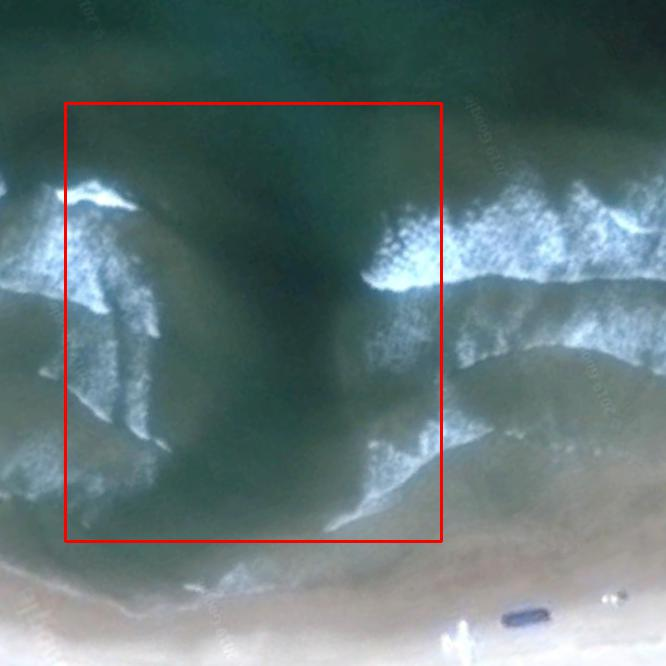

In [27]:
# yolo_annotations = read_yolo_annotations()
# print(yolo_annotations)

# yolo_bbox_image = draw_yolo_annotations('rip-331', yolo_annotations)


# cv.imwrite('rip-331-ann.png', yolo_bbox_image)
# show_image(yolo_bbox_image)

In [ ]:
if (CREATE_YOLO_ANNOTATIONS == True):
    print("Reading labels...")
    images_dict = read_RIP_annotations()
    print("Converting annotations to yolo format and writing files.")
    convert_to_yolo(images_dict)
    print("Finished writing yolo annotations to files.")
else:
    print("Yolo annotations already created (assumption). Skipping the read and write part.")


In [ ]:
# quickfix because apparently there are more RIP images than annotations
# final fix should involve cleaning the dataset completely

def build_files_from_annotations(annotations, path):
    images = []
    for item in annotations:
        name = item.split('/')[-1].split('.')[-2]
        complete_path = path + name + '.png'
        images.append(complete_path)
    return images

In [ ]:
# Paritioning the dataset

yolo_annotations_files.sort()
# yolo_annotations_files

images_rip = build_files_from_annotations(yolo_annotations_files, './data/training_data/with_rips/')

# images_rip.sort()
# images_rip

# images_norip.sort()
# images_norip

# len(images_rip)
# len(yolo_annotations_files)
train_images, val_images, train_annotations, val_annotations = train_test_split(images_rip, yolo_annotations_files, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [ ]:
def copy_files_to_folder(list_of_files, destination_folder):
    for file in list_of_files:
        try:
            shutil.copy(file, destination_folder)
        except:
            print(file)
            assert False


In [ ]:
# Move the files
if (COPY_FILES == True):
    copy_files_to_folder(train_images, TRAIN_FOLDER)
    copy_files_to_folder(test_images, TEST_FOLDER)
    copy_files_to_folder(val_images, VAL_FOLDER)

    copy_files_to_folder(train_annotations, ANNOTATIONS_TRAIN_FOLDER)
    copy_files_to_folder(test_annotations, ANNOTATIONS_TEST_FOLDER)
    copy_files_to_folder(val_annotations, ANNOTATIONS_VAL_FOLDER)

In [ ]:
#### Test functions box
from IPython.display import clear_output, Image, display

def print_initial_bbox(images_dict):
    for image in images_dict: 
        img_original = cv.imread(os.path.join(RIPS_FOLDER, image["filename"]))
        img = img_original.copy()
        cv.rectangle(img, (int(image['xmax']), int(image['ymax'])), (int(image['xmin']), int(image['ymin'])), (0, 0, 255), 2)
        show_image(img)
        

In [ ]:
# YOLO train v5s
!python ./yolov5/train.py --img 640 --cfg ./yolov5/models/yolov5s.yaml --hyp ./yolov5/data/hyps/hyp.scratch.yaml --batch 32 --epochs 100 --data ./yolov5/rip_detection.yaml --weights ./yolov5/yolov5s.pt --workers 24 --name yolo_v5s

train: weights=./yolov5/yolov5s.pt, cfg=./yolov5/models/yolov5s.yaml, data=./yolov5/rip_detection.yaml, hyp=./yolov5/data/hyps/hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=24, project=runs/train, entity=None, name=test_v5s, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0
github: skipping check (Docker image), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v5.0-351-ge96c74b torch 1.8.0a0+52ea372 CUDA:0 (Quadro P5000, 16278.5625MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0

In [ ]:
# YOLO train v5m
!python ./yolov5/train.py --img 640 --cfg ./yolov5/models/yolov5m.yaml --hyp ./yolov5/data/hyps/hyp.scratch.yaml --batch 32 --epochs 100 --data ./yolov5/rip_detection.yaml --weights ./yolov5/yolov5m.pt --workers 24 --name yolo_v5m

train: weights=./yolov5/yolov5m.pt, cfg=./yolov5/models/yolov5m.yaml, data=./yolov5/rip_detection.yaml, hyp=./yolov5/data/hyps/hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=24, project=runs/train, entity=None, name=yolo_v5m, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0
github: skipping check (Docker image), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v5.0-351-ge96c74b torch 1.8.0a0+52ea372 CUDA:0 (Quadro P5000, 16278.5625MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
# YOLO detection on test pictures
!python ./yolov5/detect.py --source ./data/images/test --weights ./runs/train/rip_current_det28/weights/best.pt --conf 0.25 --name rip_current_det

detect: weights=['./runs/train/rip_current_det28/weights/best.pt'], source=./data/images/test, imgsz=640, conf_thres=0.05, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=rip_current_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
requirements: /notebooks/RIPCurrentDetection/requirements.txt not found, check failed.
YOLOv5 🚀 v5.0-351-ge96c74b torch 1.8.0a0+52ea372 CUDA:0 (Quadro P5000, 16278.5625MB)

Fusing layers... 
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPs
image 1/163 /notebooks/RIPCurrentDetection/data/images/test/rip-1005.png: 640x640 3 rips, Done. (0.017s)
image 2/163 /notebooks/RIPCurrentDetection/data/images/test/rip-1018.png: 640x640 3 rips, Done. (0.016s)
image 3/163 /notebooks/RIPCurrentDetection/data/images/test/rip-1035.png: 640x640

In [ ]:
# test does not work, not sure why. Can't find test.py file
# !python ./yolov5/test.py --weights ./runs/train/rip_current_det28/weights/best.pt --data ./yolov5/rip_detection.yaml --task test --name rip_current_det

python: can't open file './yolov5/test.py': [Errno 2] No such file or directory


In [ ]:
# YOLO detection on video
!python ./yolov5/detect.py --source ./data/training_data/test_videos/with_rips/rip_03.mp4 --weights ./runs/train/rip_current_det28/weights/best.pt --conf 0.1 --name rip_current_video03

detect: weights=['./runs/train/rip_current_det28/weights/best.pt'], source=./data/training_data/without_rips/, imgsz=640, conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=rip_current_nowrips, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
requirements: /notebooks/RIPCurrentDetection/requirements.txt not found, check failed.
YOLOv5 🚀 v5.0-351-ge96c74b torch 1.8.0a0+52ea372 CUDA:0 (Quadro P5000, 16278.5625MB)

Fusing layers... 
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPs
image 1/702 /notebooks/RIPCurrentDetection/data/training_data/without_rips/1.png: 608x640 1 rip, Done. (0.031s)
image 2/702 /notebooks/RIPCurrentDetection/data/training_data/without_rips/10.png: 544x640 Done. (0.015s)
image 3/702 /notebooks/RIPCurrentDetection/data/traini

In [57]:
# COCO
!python ./yolov5/train.py --img 640 --cfg ./yolov5/models/yolov5s.yaml --hyp ./yolov5/data/hyps/hyp.scratch.yaml --batch 128 --epochs 100 --data ./yolov5/data/coco_person_rip.yaml --weights ./yolov5/yolov5s.pt --workers 24 --name yolo_person_rip

train: weights=./yolov5/yolov5s.pt, cfg=./yolov5/models/yolov5s.yaml, data=./yolov5/data/coco_person_rip.yaml, hyp=./yolov5/data/hyps/hyp.scratch.yaml, epochs=100, batch_size=128, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=24, project=runs/train, entity=None, name=yolo_person_rip, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0
github: skipping check (Docker image), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v5.0-351-ge96c74b torch 1.8.0a0+52ea372 CUDA:0 (Quadro P5000, 16278.5625MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.

In [ ]:
# YOLO detection on video
!python ./yolov5/detect.py --source ./datasets/training_data/test_videos/with_rips/rip_21.mp4 --weights ./runs/train/yolo_coco_full2/weights/best.pt --conf 0.1 --name yolo_coco_full21

detect: weights=['./runs/train/yolo_coco_full2/weights/best.pt'], source=./datasets/training_data/test_videos/with_rips/rip_21.mp4, imgsz=640, conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_coco_full21, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
requirements: /notebooks/RIPCurrentDetection/requirements.txt not found, check failed.
YOLOv5 🚀 v5.0-351-ge96c74b torch 1.8.0a0+52ea372 CUDA:0 (Quadro P5000, 16278.5625MB)

Fusing layers... 
Model Summary: 224 layers, 7269670 parameters, 0 gradients, 17.0 GFLOPs
video 1/1 (1/1011) /notebooks/RIPCurrentDetection/datasets/training_data/test_videos/with_rips/rip_21.mp4: 384x640 6 persons, 1 kite, 3 surfboards, Done. (0.019s)
video 1/1 (2/1011) /notebooks/RIPCurrentDetection/datasets/training_data/test_videos/with_r

In [ ]:
# needs improvement to actually make sense
def change_yolo_annotation_class(annotations, new_class):
    for yolo_file in coco_rip_files:
        print(yolo_file)
        file = open(yolo_file, 'r')
        line = file.readline()
        split_line = line.split(' ')
        file.close()
        file = open(yolo_file, 'w')
        split_line[0] = str(1)
        split_line[1] = str(split_line[1])
        split_line[2] = str(split_line[2])
        split_line[3] = str(split_line[3])
        split_line[4] = str(split_line[4])
        newline = (' ').join(split_line)    
        file.write(newline)
        file.close()

In [ ]:
coco_rip_train = './datasets/coco/labels/rip_train'
coco_rip_val = './datasets/coco/labels/rip_val'
coco_rip_test = './datasets/coco/labels/rip_test'
coco_rip_annotations = [coco_rip_train, coco_rip_val, coco_rip_test]


In [ ]:
# file rip-1123.txt has a negative value
# make a function to search for negative values

# changes annotations for rip currents
for coco_rip in coco_rip_annotations:
    print("changing annotations in ", coco_rip)
    coco_rip_files = glob.glob(os.path.join(coco_rip, "rip-*.txt")) 
    for yolo_file in coco_rip_files:
#         print(yolo_file)
        file = open(yolo_file, 'r')
        line = file.readline()
        split_line = line.split(' ')
        file.close()
        file = open(yolo_file, 'w')
        split_line[0] = str(1)
        split_line[1] = str(split_line[1])
        split_line[2] = str(split_line[2])
        split_line[3] = str(split_line[3])
        split_line[4] = str(split_line[4])
        newline = (' ').join(split_line)    
        file.write(newline)
        file.close()
    print("Done.")

changing annotations in  ./datasets/coco/labels/rip_train
Done.
changing annotations in  ./datasets/coco/labels/rip_val
Done.
changing annotations in  ./datasets/coco/labels/rip_test
Done.


In [33]:
coco_train = './datasets/coco/labels/train2017'
coco_val = './datasets/coco/labels/val2017'

coco_images_train = './datasets/coco/images/train2017'
coco_images_val = './datasets/coco/labels/val2017'
coco_annotations = [coco_train, coco_val]
coco_images = [coco_images_train, coco_images_val]

In [50]:
def get_image_from_annotation_path(annotation_path):
    train_or_val = annotation_path.split('/')[-2]
    image_name = annotation_path.split('/')[-1].split('.')[-2]
    return os.path.join('./datasets/coco/images/', train_or_val, image_name + '.jpg')

In [55]:
# parse the entire coco dataset annotations and only keep the ones with class '0', aka 'person'
# IT DELETES ABOUT HALF OF THE DATASET, USE CAREFULLY
count = 12
for coco_ann in coco_annotations:
    print("changing annotations in ", coco_ann)
    coco_ann_files = glob.glob(os.path.join(coco_ann, "*.txt")) 
    coco_ann_files.sort()
    for yolo_file in coco_ann_files:
#         print(yolo_file)
        file = open(yolo_file, 'r')
        new_content = ""
        for line in file:
            split_line = line.split(' ')
            split_line[0] = str(split_line[0])
            split_line[1] = str(split_line[1])
            split_line[2] = str(split_line[2])
            split_line[3] = str(split_line[3])
            split_line[4] = str(split_line[4])
            if (split_line[0] == '0'):
                newline = (' ').join(split_line)
                new_content += newline
        file.close()
        if (not new_content):
            if os.path.exists(yolo_file):
                os.remove(yolo_file)
                os.remove(get_image_from_annotation_path(yolo_file))
                count += 1
        else:
            file = open(yolo_file, 'w')
            file.write(new_content)
            file.close()
    print("Done.")


changing annotations in  ./datasets/coco/labels/train2017
Done.
changing annotations in  ./datasets/coco/labels/val2017
Done.


In [56]:
count

55411